In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import json
from copy import copy
from os import path

### Make sure you decompress PDBs.tar.gz before running the code below

In [2]:
def get_NTF2_dict_and_feat(pdb_fname):
    curr_name = './PDBs/'+path.basename(pdb_fname)
    with open(pdb_fname,'r') as f:
        lines = [i[:-1] for i in f.readlines()]
    lines.reverse()
    NTF2_dict_line = ''
    features_line = ''
    pocket_res_line = ''
    for line in lines:
        if line != '':
            if 'Pckt' in line:
                pocket_res_line += '+%sA'%(line.split()[2])
            if line.split()[0] == 'FEATURES':
                features_line = line
            if line.split()[0] == 'BENTF2DICT':
                NTF2_dict_line = line
                break
    NTF2 = json.loads(' '.join(NTF2_dict_line.split()[1:]))
    features = json.loads(' '.join(features_line.split()[1:]))
    features['pckt_res'] = pocket_res_line
    return NTF2,features

def get_features_dict(pdb_fname):
    NTF2,features = get_NTF2_dict_and_feat(pdb_fname)
    ring_dict = NTF2['ring_dict']
    sheet_dict = ring_dict['sheet_dict']
    H3_S3_connections = {"BBGB":4,'BulgeAndB':4,'ClassicDirect':0,'GB':2,'GBA':3,'BA':2}
    opening_dict = {'Classic':1, 'Tropical':0}
    return_dict = {}
    
    return_dict['has_cHelix'] = int(NTF2['has_cHelix'])
    return_dict['opening'] = opening_dict[NTF2['Opening']]
    return_dict['h1_len'] = NTF2['h1_len']
    return_dict['h2_len'] = NTF2['h2_len']
    
    return_dict['h3_len'] = ring_dict['h_len']
    return_dict['hairpin_len'] = ring_dict['hairpin_len']
    return_dict['H3_S3_len'] = H3_S3_connections[ring_dict['connection_type']]
    
    return_dict['long_arm_l'] = sheet_dict['long_arm_l']
    return_dict['short_arm_l'] = sheet_dict['short_arm_l']
    return_dict['Second_bulge_E3'] = int(sheet_dict['Second_bulge_E3'])
    return_dict['base_width'] = sheet_dict['base_width']
    return_dict['CurvedLongArm'] = int(sheet_dict['CurvedLongArm'])
    return_dict['ExtendedE6'] = int(sheet_dict['ExtendedE6'])
    return_dict['E3_MainBulgeCurve'] = sheet_dict['E3_MainBulgeCurve']
    return_dict['E3_SecBulgeCurve'] = sheet_dict['E3_SecBulgeCurve'] or 0
    return_dict['Second_b_place'] = sheet_dict['Second_b_place'] or 0
    
    keys = ['shoot','prot','long_arm_ang','dist','pckt_res']
    for k in keys:
        return_dict[k] = features[k]
    
    return return_dict

def get_CLIPPERS_overlap_to_pocket(clp_str,pckt_str):
    clp_set = { int(i) for i in clp_str.replace('+','').split('A')[:-1] }
    pckt_set = { int(i) for i in pckt_str.replace('+','').split('A')[:-1] }
    overlap = len([ i for i in clp_set if i in pckt_set])/len(clp_set)
    return overlap

In [3]:
def add_sheet_quadrant(sheet_feature_dict):
    return_type = -1
    if sheet_feature_dict['long_arm_l']==2:
        # Types 1-9
        if sheet_feature_dict['base_width']==3:
            # Types 1-3
            if sheet_feature_dict['E3_MainBulgeCurve']==1:
                return_type = 1
            elif sheet_feature_dict['E3_MainBulgeCurve']==2:
                return_type = 2
            elif sheet_feature_dict['E3_MainBulgeCurve']==3:
                return_type = 3
        elif sheet_feature_dict['base_width']==5:
            # Types 4-9
            if sheet_feature_dict['short_arm_l']==1:
                # Types 4-6
                if sheet_feature_dict['E3_MainBulgeCurve']==1:
                    return_type = 4
                elif sheet_feature_dict['E3_MainBulgeCurve']==2:
                    return_type = 5
                elif sheet_feature_dict['E3_MainBulgeCurve']==3:
                    return_type = 6
            elif sheet_feature_dict['short_arm_l']==2:
                # Types 7-9
                if sheet_feature_dict['E3_MainBulgeCurve']==1:
                    return_type = 7
                elif sheet_feature_dict['E3_MainBulgeCurve']==2:
                    return_type = 8
                elif sheet_feature_dict['E3_MainBulgeCurve']==3:
                    return_type = 9
    elif sheet_feature_dict['long_arm_l']==3:
        # Types 10-39
        if sheet_feature_dict['base_width']==3:
            # Types 10-19
            if sheet_feature_dict['Second_bulge_E3'] == 0:
                # Types 10-13
                if sheet_feature_dict['CurvedLongArm'] == 0:
                    # Types 10,11
                    if sheet_feature_dict['E3_MainBulgeCurve']==2:
                        return_type = 10
                    elif sheet_feature_dict['E3_MainBulgeCurve']==3:
                        return_type = 11
                elif sheet_feature_dict['CurvedLongArm'] == 1:
                    # Types 12,13
                    if sheet_feature_dict['E3_MainBulgeCurve']==2:
                        return_type = 12
                    elif sheet_feature_dict['E3_MainBulgeCurve']==3:
                        return_type = 13
            elif sheet_feature_dict['Second_bulge_E3'] == 1:
                # Types 14-19
                if sheet_feature_dict['E3_MainBulgeCurve']==2:
                    # Types 14-16
                    if sheet_feature_dict['E3_SecBulgeCurve']==1:
                        return_type = 14
                    elif sheet_feature_dict['E3_SecBulgeCurve']==2:
                        return_type = 15
                    elif sheet_feature_dict['E3_SecBulgeCurve']==3:
                        return_type = 16
                if sheet_feature_dict['E3_MainBulgeCurve']==3:
                    # Types 17-19
                    if sheet_feature_dict['E3_SecBulgeCurve']==1:
                        return_type = 17
                    elif sheet_feature_dict['E3_SecBulgeCurve']==2:
                        return_type = 18
                    elif sheet_feature_dict['E3_SecBulgeCurve']==3:
                        return_type = 19  
        elif sheet_feature_dict['base_width']==5:
            # Types 20-39
            if sheet_feature_dict['short_arm_l']==1:
                # Types 20-29
                if sheet_feature_dict['Second_bulge_E3'] == 0:
                    # Types 20-23
                    if sheet_feature_dict['CurvedLongArm'] == 0:
                        # Types 20,21
                        if sheet_feature_dict['E3_MainBulgeCurve']==2:
                            return_type = 20
                        elif sheet_feature_dict['E3_MainBulgeCurve']==3:
                            return_type = 21
                    elif sheet_feature_dict['CurvedLongArm'] == 1:
                        # Types 22,23
                        if sheet_feature_dict['E3_MainBulgeCurve']==2:
                            return_type = 22
                        elif sheet_feature_dict['E3_MainBulgeCurve']==3:
                            return_type = 23
                elif sheet_feature_dict['Second_bulge_E3'] == 1:
                    # Types 24-29
                    if sheet_feature_dict['E3_MainBulgeCurve']==2:
                        # Types 24-26
                        if sheet_feature_dict['E3_SecBulgeCurve']==1:
                            return_type = 24
                        elif sheet_feature_dict['E3_SecBulgeCurve']==2:
                            return_type = 25
                        elif sheet_feature_dict['E3_SecBulgeCurve']==3:
                            return_type = 26
                    elif sheet_feature_dict['E3_MainBulgeCurve']==3:
                        # Types 27-29
                        if sheet_feature_dict['E3_SecBulgeCurve']==1:
                            return_type = 27
                        elif sheet_feature_dict['E3_SecBulgeCurve']==2:
                            return_type = 28
                        elif sheet_feature_dict['E3_SecBulgeCurve']==3:
                            return_type = 29
            elif sheet_feature_dict['short_arm_l']==2:
                # Types 30-39
                if sheet_feature_dict['Second_bulge_E3'] == 0:
                    # Types 30-33
                    if sheet_feature_dict['CurvedLongArm'] == 0:
                        # Types 30,31
                        if sheet_feature_dict['E3_MainBulgeCurve']==2:
                            return_type = 30
                        elif sheet_feature_dict['E3_MainBulgeCurve']==3:
                            return_type = 31
                    elif sheet_feature_dict['CurvedLongArm'] == 1:
                        # Types 32,33
                        if sheet_feature_dict['E3_MainBulgeCurve']==2:
                            return_type = 32
                        elif sheet_feature_dict['E3_MainBulgeCurve']==3:
                            return_type = 33
                elif sheet_feature_dict['Second_bulge_E3'] == 1:
                    # Types 34-39
                    if sheet_feature_dict['E3_MainBulgeCurve']==2:
                        # Types 34-36
                        if sheet_feature_dict['E3_SecBulgeCurve']==1:
                            return_type = 34
                        elif sheet_feature_dict['E3_SecBulgeCurve']==2:
                            return_type = 35
                        elif sheet_feature_dict['E3_SecBulgeCurve']==3:
                            return_type = 36
                    elif sheet_feature_dict['E3_MainBulgeCurve']==3:
                        # Types 37-39
                        if sheet_feature_dict['E3_SecBulgeCurve']==1:
                            return_type = 37
                        elif sheet_feature_dict['E3_SecBulgeCurve']==2:
                            return_type = 38
                        elif sheet_feature_dict['E3_SecBulgeCurve']==3:
                            return_type = 39
    elif sheet_feature_dict['long_arm_l']==4:
        # Types 40-65
        if sheet_feature_dict['base_width']==3:
            # Types 40-49
            if sheet_feature_dict['Second_bulge_E3'] == 0:
                # Types 40,41
                if sheet_feature_dict['CurvedLongArm'] == 0:
                    return_type = 40
                elif sheet_feature_dict['CurvedLongArm'] == 1:
                    return_type = 41
            elif sheet_feature_dict['Second_bulge_E3'] == 1:
                # Types 42-47
                if sheet_feature_dict['E3_MainBulgeCurve']==2:
                    # Types 42-45
                    if sheet_feature_dict['E3_SecBulgeCurve']==1:
                        return_type = 42
                    elif sheet_feature_dict['E3_SecBulgeCurve']==2:
                        if sheet_feature_dict['Second_b_place']==2:
                            return_type = 43
                        elif sheet_feature_dict['Second_b_place']==1:
                            return_type = 48
                    elif sheet_feature_dict['E3_SecBulgeCurve']==3:
                        return_type = 44
                elif sheet_feature_dict['E3_MainBulgeCurve']==3:
                    # Types 45-47
                    if sheet_feature_dict['E3_SecBulgeCurve']==1:
                        return_type = 45
                    elif sheet_feature_dict['E3_SecBulgeCurve']==2:
                        if sheet_feature_dict['Second_b_place']==2:
                            return_type = 46
                        elif sheet_feature_dict['Second_b_place']==1:
                            return_type = 49
                    elif sheet_feature_dict['E3_SecBulgeCurve']==3:
                        return_type = 47
        elif sheet_feature_dict['base_width']==5:
            # Types 50-57
            if sheet_feature_dict['short_arm_l']==1:
                # Types 48-53
                if sheet_feature_dict['E3_MainBulgeCurve']==2:
                    # Types 48-50
                    if sheet_feature_dict['E3_SecBulgeCurve']==1:
                        return_type = 50
                    elif sheet_feature_dict['E3_SecBulgeCurve']==2:
                        if sheet_feature_dict['Second_b_place']==2:
                            return_type = 51
                        elif sheet_feature_dict['Second_b_place']==1:    
                            return_type = 56
                    elif sheet_feature_dict['E3_SecBulgeCurve']==3:
                        return_type = 52
                elif sheet_feature_dict['E3_MainBulgeCurve']==3:
                    # Types 51-53
                    if sheet_feature_dict['E3_SecBulgeCurve']==1:
                        return_type = 53
                    elif sheet_feature_dict['E3_SecBulgeCurve']==2:
                        if sheet_feature_dict['Second_b_place']==2:
                            return_type = 54
                        elif sheet_feature_dict['Second_b_place']==1:
                            return_type = 57
                    elif sheet_feature_dict['E3_SecBulgeCurve']==3:
                        return_type = 55
            elif sheet_feature_dict['short_arm_l']==2:
                # Types 54-59
                if sheet_feature_dict['E3_MainBulgeCurve']==2:
                    # Types 54-56
                    if sheet_feature_dict['E3_SecBulgeCurve']==1:
                        return_type = 58
                    elif sheet_feature_dict['E3_SecBulgeCurve']==2:
                        if sheet_feature_dict['Second_b_place']==2:
                            return_type = 59
                        elif sheet_feature_dict['Second_b_place']==1:
                            return_type = 64
                    elif sheet_feature_dict['E3_SecBulgeCurve']==3:
                        return_type = 60
                elif sheet_feature_dict['E3_MainBulgeCurve']==3:
                    # Types 57-58
                    if sheet_feature_dict['E3_SecBulgeCurve']==1:
                        return_type = 61
                    elif sheet_feature_dict['E3_SecBulgeCurve']==2:
                        if sheet_feature_dict['Second_b_place']==2:
                            return_type = 62
                        elif sheet_feature_dict['Second_b_place']==1:
                            return_type = 65
                    elif sheet_feature_dict['E3_SecBulgeCurve']==3:
                        return_type = 63
    assert return_type != -1
    sheet_feature_dict['quadrant'] = return_type
    return sheet_feature_dict

In [4]:
def generate_heat_map_matrix(df,process='sum',attribute='attribute'):
    # The df data frame should have a 'quadrant' and an 'attribute' column
    process_types = ['sum','av']
    assert process in process_types
    assert ('quadrant' in df.columns)
    sheet_types_dict = { i:[] for i in range(1,66) }
    for key in sheet_types_dict.keys():
        values = df[attribute].where(df.quadrant == key).dropna().values
        if process == 'sum':
            sheet_types_dict[key] = sum(values)
        else:
            sheet_types_dict[key] = np.average(values)
    matrix = np.zeros((9,13))-999.0
    index_dict = {1:(0,0), 2:(0,1),3:(0,2),\
                  4:(1,0), 5:(1,1),6:(1,2),\
                  7:(2,0), 8:(2,1),9:(2,2),\
                           10:(3,1),11:(3,2),12:(3,3),13:(3,4),14:(3,5),15:(3,6),16:(3,7),17:(3,8),18:(3,9),19:(3,10),\
                           20:(4,1),21:(4,2),22:(4,3),23:(4,4),24:(4,5),25:(4,6),26:(4,7),27:(4,8),28:(4,9),29:(4,10),\
                           30:(5,1),31:(5,2),32:(5,3),33:(5,4),34:(5,5),35:(5,6),36:(5,7),37:(5,8),38:(5,9),39:(5,10),\
                                    40:(6,2),         41:(6,4),42:(6,5),43:(6,6),44:(6,7),45:(6,8),46:(6,9),47:(6,10),48:(6,11),49:(6,12),\
                                                               50:(7,5),51:(7,6),52:(7,7),53:(7,8),54:(7,9),55:(7,10),56:(7,11),57:(7,12),\
                                                               58:(8,5),59:(8,6),60:(8,7),61:(8,8),62:(8,9),63:(8,10),64:(8,11),65:(8,12)}
    for key in index_dict.keys():
        if key not in sheet_types_dict.keys():
            matrix[index_dict[key]] = -999.0
        else:
            matrix[index_dict[key]] = sheet_types_dict[key]
    
    return [ index_dict[key] for key in index_dict.keys()],matrix

In [53]:
# Uncomment this block to regenerate all_from_same_as_ordered_and_pocket_enhanced.csv
'''
all_loecked_sheet_files_fname = './pocket_metrics.csv'

input_features_df = pd.read_csv(all_loecked_sheet_files_fname, index_col=0).dropna()


new_sheet_df = pd.DataFrame.from_dict( { fname:add_sheet_quadrant(get_features_dict(fname)) for fname in input_features_df.index}, orient='index')
main_df = pd.concat([input_features_df,new_sheet_df], axis=1, sort=True)

main_df['TypeofPocket'] = np.array([ 0 for i in range(len(main_df))])

# Adding some additional features
# Pocket overlap with actual NTF2 pocket
main_df['pockt_overlap'] = np.array([get_CLIPPERS_overlap_to_pocket(main_df.iloc[i].ResidueNumberList,main_df.iloc[i].pckt_res) \
                                     for i in range(len(main_df))])

# Pocket overlap with actual NTF2 pocket
pocket_true = np.array([ 1 if (main_df.loc[i].Volume>200) and (main_df.loc[i].pockt_overlap>0.25) else 0 for i in main_df.index ])
main_df['has_pocket'] = pocket_true
pocket_cleft = np.array([ 1 if (main_df.loc[i].maxTD<15) and (main_df.loc[i].has_pocket==1) else 0 for i in main_df.index ])
main_df['is_cleft'] = pocket_cleft
pocket_deep = np.array([ 1 if (main_df.loc[i].maxTD>15) and (main_df.loc[i].has_pocket==1) else 0 for i in main_df.index ])
main_df['is_deep'] = pocket_deep
is_elong = np.array([ 1 if (main_df.loc[i].longestdimension/3>main_df.loc[i].middledimension) and (main_df.loc[i].has_pocket==1) else 0 for i in main_df.index ])
main_df['is_elong'] = is_elong
is_sphere = np.array([ 1 if (main_df.loc[i].longestdimension/2<main_df.loc[i].middledimension) and (main_df.loc[i].has_pocket==1) else 0 for i in main_df.index ])
main_df['is_sphere'] = is_sphere
main_df['count'] = np.zeros(len(main_df))+1

main_df.to_csv('./all_from_same_as_ordered_and_pocket_enhanced.csv')
'''

In [5]:
main_df = pd.read_csv('./all_from_same_as_ordered_and_pocket_enhanced.csv',index_col=0).dropna()

In [6]:
labels = np.zeros((9,13), dtype=object) #

index_dict = {1:(0,0), 2:(0,1),3:(0,2),\
                  4:(1,0), 5:(1,1),6:(1,2),\
                  7:(2,0), 8:(2,1),9:(2,2),\
                           10:(3,1),11:(3,2),12:(3,3),13:(3,4),14:(3,5),15:(3,6),16:(3,7),17:(3,8),18:(3,9),19:(3,10),\
                           20:(4,1),21:(4,2),22:(4,3),23:(4,4),24:(4,5),25:(4,6),26:(4,7),27:(4,8),28:(4,9),29:(4,10),\
                           30:(5,1),31:(5,2),32:(5,3),33:(5,4),34:(5,5),35:(5,6),36:(5,7),37:(5,8),38:(5,9),39:(5,10),\
                                    40:(6,2),         41:(6,4),42:(6,5),43:(6,6),44:(6,7),45:(6,8),46:(6,9),47:(6,10),48:(6,11),49:(6,12),\
                                                               50:(7,5),51:(7,6),52:(7,7),53:(7,8),54:(7,9),55:(7,10),56:(7,11),57:(7,12),\
                                                               58:(8,5),59:(8,6),60:(8,7),61:(8,8),62:(8,9),63:(8,10),64:(8,11),65:(8,12)}
for i in range(1,66):
    labels[index_dict[i]] = str(i)

for i in range(9):
    for j in range(13):
        if labels[i][j] == 0:
            labels[i][j] = ''

print(labels)      

[['1' '2' '3' '' '' '' '' '' '' '' '' '' '']
 ['4' '5' '6' '' '' '' '' '' '' '' '' '' '']
 ['7' '8' '9' '' '' '' '' '' '' '' '' '' '']
 ['' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '' '']
 ['' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '' '']
 ['' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '' '']
 ['' '' '40' '' '41' '42' '43' '44' '45' '46' '47' '48' '49']
 ['' '' '' '' '' '50' '51' '52' '53' '54' '55' '56' '57']
 ['' '' '' '' '' '58' '59' '60' '61' '62' '63' '64' '65']]


In [7]:
def plot_table(main_df,cbar_bool=True,att='',process='av', **kwargs):
    cmap = copy(plt.cm.YlGnBu)
    #sns.set(font_scale=1.4)
    idx, mtx = generate_heat_map_matrix(main_df,process=process,attribute=att)
    values = [ mtx[i[0]][i[1]] for i in idx]

    cmap.set_under('xkcd:silver')
    fig, ax = plt.subplots(figsize=(17, 10))
    sns.heatmap(mtx,vmin=min(values), vmax=max(values), xticklabels=False, yticklabels=False,cmap=cmap,\
                cbar=False, annot=labels,alpha=0.0,fmt='',ax=ax)#, annot_kws={'ha':'right','va':'bottom','fontsize':20}
    #cmap.set_under('xkcd:silver',-2000)
    vmin = min(values)
    vmax = max(values)
    if ('vmin_in' in kwargs) and ('vmax_in' in kwargs):
        vmin = kwargs['vmin_in']
        vmax = kwargs['vmax_in']
    sns.heatmap(mtx,vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False,cmap=cmap,alpha=1.0,\
                cbar=cbar_bool,ax=ax)#,cbar_kws={'label': att}

    
    return ax

In [8]:
# Get ordered stability scores and features
final_features_and_stab_sc_CHIP2 = pd.read_csv('final_features_and_stab_sc_CHIP2.csv',index_col=0)
nu_udx_dict = { idx.split('/')[-1].split('_')[0]:idx for idx in main_df.index}
nu_idx = [ nu_udx_dict[i] for i in final_features_and_stab_sc_CHIP2.index ]
final_features_and_stab_sc_CHIP2.index = nu_idx

In [9]:
enhanced_main_df = pd.concat([main_df,final_features_and_stab_sc_CHIP2],axis=1, sort=True)
enhanced_main_df['is_stable'] = np.array([ 1 if (enhanced_main_df.loc[i].stability_sc > 1.55) else 0 for i in main_df.index ])

In [10]:
update_Vol = np.array([ 0.0 if (enhanced_main_df.loc[i].pockt_overlap<0.25) else enhanced_main_df.loc[i]['Volume'] for i in enhanced_main_df.index ])
enhanced_main_df['nuVolume']=update_Vol


In [11]:
aspect_ratio = np.array([ max(enhanced_main_df.loc[i].longestdimension,enhanced_main_df.loc[i].middledimension)/min(enhanced_main_df.loc[i].longestdimension,enhanced_main_df.loc[i].middledimension) for i in enhanced_main_df.index ])
enhanced_main_df['aspect_ratio']=aspect_ratio


In [12]:
cleft_character = np.array([enhanced_main_df.loc[i].mean_height/(enhanced_main_df.loc[i].nuVolume+1) for i in enhanced_main_df.index ])
enhanced_main_df['cleft_character']=cleft_character


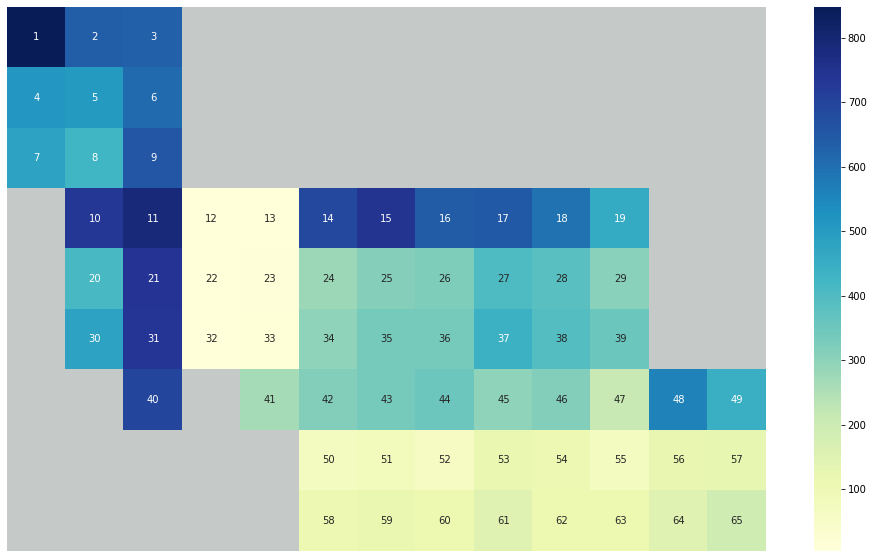

In [13]:
# Counts
fig = plot_table(enhanced_main_df,att='count',process='sum')

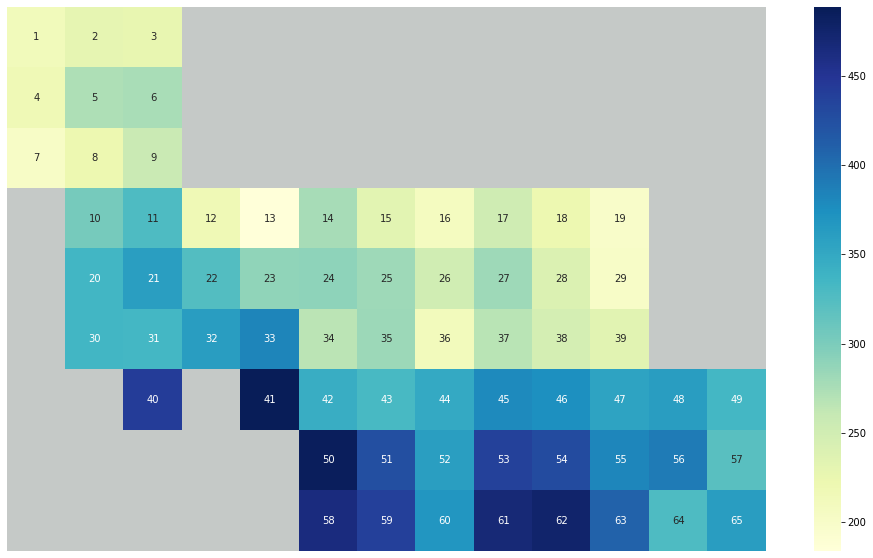

In [14]:
# Average volume
fig = plot_table(enhanced_main_df.where(enhanced_main_df.nuVolume>0),att='nuVolume',process='av')

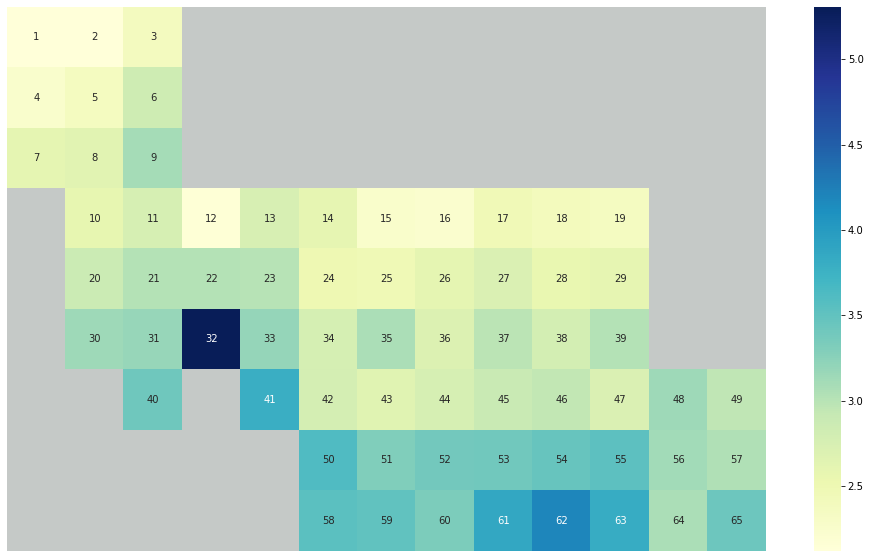

In [19]:
# Average depth
fig = plot_table(enhanced_main_df.where(enhanced_main_df.nuVolume>0),att='mean_height',process='av')

/home/basantab/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/basantab/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


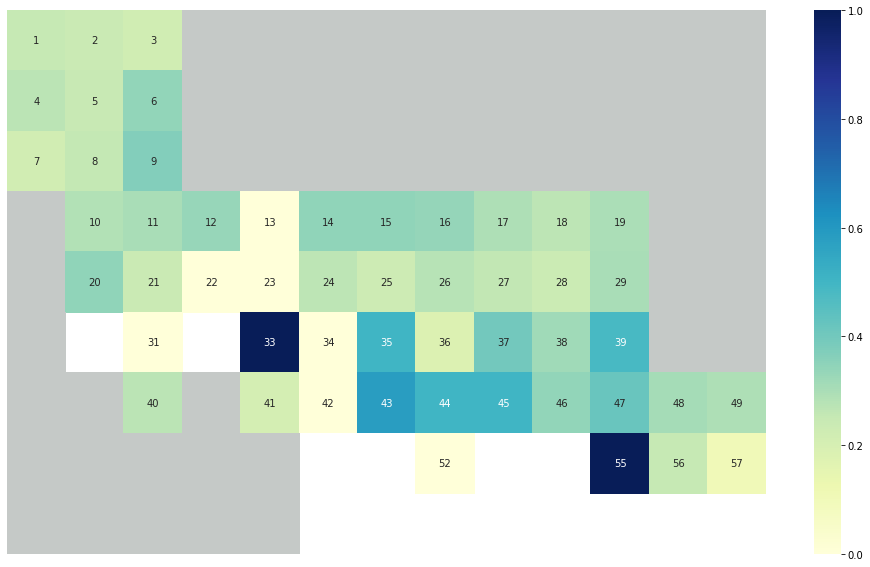

In [15]:
# Stable designs count
fig = plot_table(enhanced_main_df.dropna(),att='is_stable',process='av')


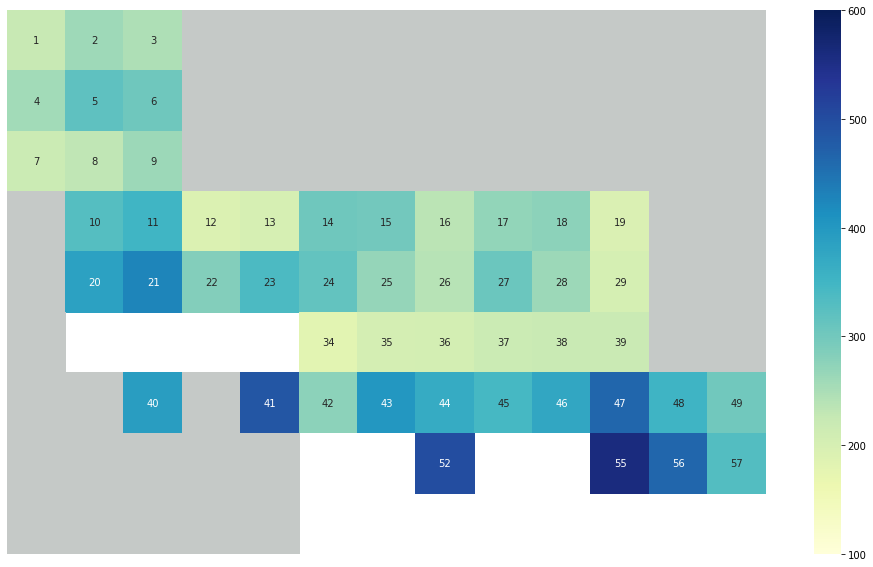

In [16]:
# Average pocket volume in stable designs
fig = plot_table(enhanced_main_df.dropna().where(enhanced_main_df.nuVolume > 0).dropna()\
                 ,att='nuVolume',process='av',vmin_in=100,vmax_in=600)


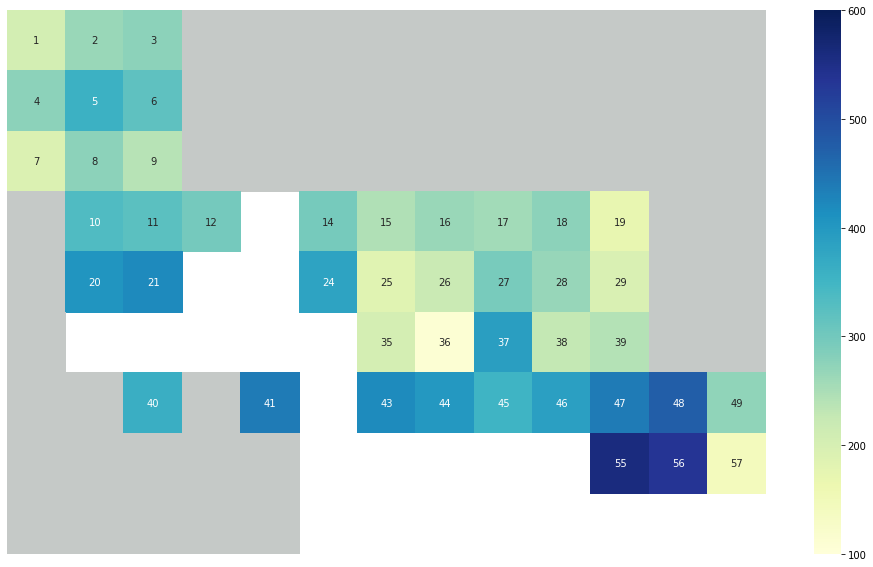

In [17]:
fig = plot_table(enhanced_main_df.dropna().where(enhanced_main_df.nuVolume > 0).where(enhanced_main_df.is_stable == 1).dropna(),\
                 att='nuVolume',process='av',vmin_in=100,vmax_in=600)

In [18]:
#enhanced_main_df.to_csv('./final_enhanced_Fig3.csv')

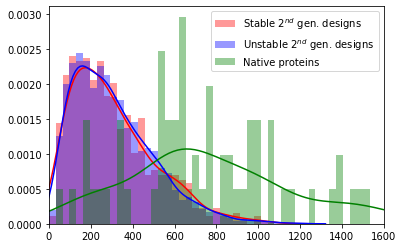

In [25]:
bins = np.linspace(0,1600,50)
native_vols = pd.read_csv('./native_pockets_all_infor.csv',index_col=0)

sns.distplot(enhanced_main_df.dropna().where(enhanced_main_df.nuVolume >0).nuVolume.where(enhanced_main_df.dropna().is_stable==1.0).dropna()\
             ,label='Stable $2^{nd}$ gen. designs',color='red',bins=bins)
sns.distplot(enhanced_main_df.dropna().where(enhanced_main_df.nuVolume >0).nuVolume.where(enhanced_main_df.dropna().is_stable==0.0).dropna()\
             ,label='Unstable $2^{nd}$ gen. designs',color='blue',bins=bins)
sns.distplot(native_vols['Volume'],label='Native proteins',color='green',bins=bins)

plt.legend()
plt.xlabel('')
plt.xlim(0,1600)
plt.show()

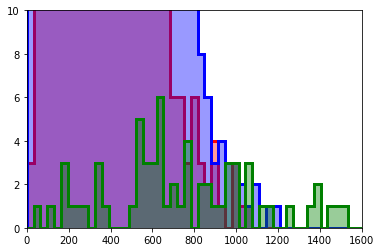

In [40]:
bins = np.linspace(0,1600,50)
native_vols = pd.read_csv('./native_pockets_all_infor.csv',index_col=0)

sns.distplot(enhanced_main_df.dropna().where(enhanced_main_df.nuVolume >0).nuVolume.where(enhanced_main_df.dropna().is_stable==1.0).dropna()\
             ,label='Stable $2^{nd}$ gen. designs',color='red',kde=False,bins=bins)
sns.distplot(enhanced_main_df.dropna().where(enhanced_main_df.nuVolume >0).nuVolume.where(enhanced_main_df.dropna().is_stable==1.0).dropna()\
             ,color='red',kde=False,bins=bins,hist_kws={"linewidth": 3, "alpha":1,"histtype": "step"})
sns.distplot(enhanced_main_df.dropna().where(enhanced_main_df.nuVolume >0).nuVolume.where(enhanced_main_df.dropna().is_stable==0.0).dropna()\
             ,label='Unstable $2^{nd}$ gen. designs',color='blue',kde=False,bins=bins)
sns.distplot(enhanced_main_df.dropna().where(enhanced_main_df.nuVolume >0).nuVolume.where(enhanced_main_df.dropna().is_stable==0.0).dropna()\
             ,color='blue',kde=False,bins=bins,hist_kws={"linewidth": 3, "alpha":1,"histtype": "step"})
sns.distplot(native_vols['Volume'],label='Native proteins',color='green',kde=False,bins=bins)
sns.distplot(native_vols['Volume'],color='green',kde=False,bins=bins,hist_kws={"linewidth": 3, "alpha":1,"histtype": "step"})

plt.xlabel('')
plt.xlim(0,1600)
plt.ylim(0,10)
plt.show()

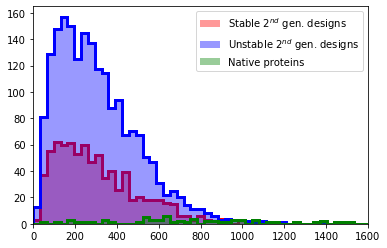

In [39]:
bins = np.linspace(0,1600,50)
native_vols = pd.read_csv('./native_pockets_all_infor.csv',index_col=0)

sns.distplot(enhanced_main_df.dropna().where(enhanced_main_df.nuVolume >0).nuVolume.where(enhanced_main_df.dropna().is_stable==1.0).dropna()\
             ,label='Stable $2^{nd}$ gen. designs',color='red',kde=False,bins=bins)
sns.distplot(enhanced_main_df.dropna().where(enhanced_main_df.nuVolume >0).nuVolume.where(enhanced_main_df.dropna().is_stable==1.0).dropna()\
             ,color='red',kde=False,bins=bins,hist_kws={"linewidth": 3, "alpha":1,"histtype": "step"})
sns.distplot(enhanced_main_df.dropna().where(enhanced_main_df.nuVolume >0).nuVolume.where(enhanced_main_df.dropna().is_stable==0.0).dropna()\
             ,label='Unstable $2^{nd}$ gen. designs',color='blue',kde=False,bins=bins)
sns.distplot(enhanced_main_df.dropna().where(enhanced_main_df.nuVolume >0).nuVolume.where(enhanced_main_df.dropna().is_stable==0.0).dropna()\
             ,color='blue',kde=False,bins=bins,hist_kws={"linewidth": 3, "alpha":1,"histtype": "step"})
sns.distplot(native_vols['Volume'],label='Native proteins',color='green',kde=False,bins=bins)
sns.distplot(native_vols['Volume'],color='green',kde=False,bins=bins,hist_kws={"linewidth": 3, "alpha":1,"histtype": "step"})

plt.legend()
plt.xlabel('')
plt.xlim(0,1600)
plt.show()